# Diffusion models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import sys

from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

project_root = Path().absolute().parent
sys.path.append(str(project_root))
project_root

PosixPath('/home/aorellan/DiffusionArcade')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from src.diffusion.model import login_huggingface

login_huggingface()

#### Utils to show images and make grids

In [5]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.asarray(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

### Dataset

In [6]:
dataset = load_dataset(
    "imagefolder",
    data_dir="../screens/",
    split="train"
)

Resolving data files:   0%|          | 0/1592 [00:00<?, ?it/s]

In [31]:
dataset

Dataset({
    features: ['image'],
    num_rows: 1592
})

In [32]:
split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset   = split_datasets["test"]

In [33]:
image_size = 128
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),   # Resize to square
    transforms.Grayscale(num_output_channels=1),   # → single‐channel “L” image
    transforms.ToTensor(),                         # → tensor in [0,1], shape = [1,H,W]
    transforms.Normalize([0.5], [0.5]),            # → tensor in [−1,1]
])


def transform(examples):
    imgs = [preprocess(img) for img in examples["image"]]
    return {"image": imgs}

train_dataset.set_transform(transform)
val_dataset.set_transform(transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

X shape: torch.Size([8, 1, 128, 128])
Batch of images in training dataset:


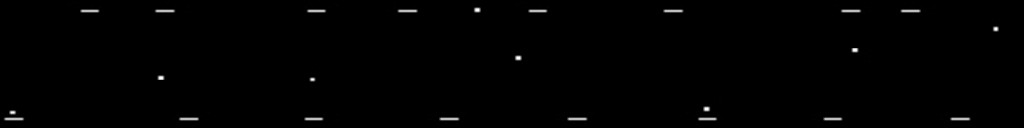

In [34]:
train_batch_images = next(iter(train_dataloader))["image"].to(device)[:8]
print("X shape:", train_batch_images.shape)

print('Batch of images in training dataset:')
show_images(train_batch_images).resize((8 * 128, 128), resample=Image.NEAREST)

X shape: torch.Size([8, 1, 128, 128])
Batch of images in validation dataset:


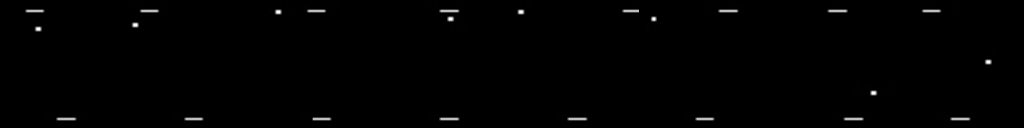

In [35]:
val_batch_images = next(iter(val_dataloader))["image"].to(device)[:8]
print("X shape:", val_batch_images.shape)

print('Batch of images in validation dataset:')
show_images(val_batch_images).resize((8 * 128, 128), resample=Image.NEAREST)

## Diffusion model

#### Forward diffusion process

In [36]:
from diffusers import DDIMScheduler # We can also use DDPM scheduler, but this is slower

timesteps = 1000

schedulers = {
    "cosine": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="squaredcos_cap_v2"
    ),
    "linear": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="linear"
    ),
}

The forward diffusion process progressively adds noise to the original image $\mathbf{x}_0$ as timestep $t$ increases.

The process is defined by the re-parameterization formula:

$$
q(\mathbf{x}_t \mid \mathbf{x}_0)
    = \mathcal{N}\!\bigl(
        \mathbf{x}_t;\,
        \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\,
        (1 - \bar{\alpha}_t)\,\mathbf{I}
      \bigr)
$$

where:

* $\mathbf{x}_t$ — noisy image at timestep $t$  
* $\sqrt{\bar{\alpha}_t}$ — scales down the original image  
* $1-\bar{\alpha}_t$ — variance of the added Gaussian noise

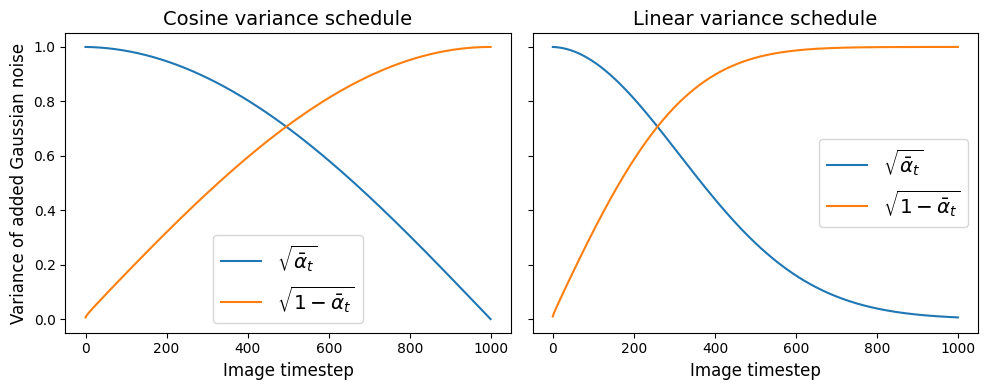

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, (name, sched) in zip(axes, schedulers.items()):
    alphas_cumprod = sched.alphas_cumprod.cpu()
    
    ax.plot(
        alphas_cumprod ** 0.5,
        label=r"$\sqrt{\bar{\alpha}_t}$"
    )
    ax.plot(
        (1 - alphas_cumprod) ** 0.5,
        label=r"$\sqrt{1 - \bar{\alpha}_t}$"
    )
    ax.set_title(f"{name.capitalize()} variance schedule", fontsize=14)
    ax.set_xlabel("Image timestep", fontsize=12)
    ax.legend(fontsize="x-large")
    
axes[0].set_ylabel("Variance of added Gaussian noise", fontsize=12)

plt.tight_layout()
plt.show()

The more time steps, the more noise is added to the original image $\mathbf{x}_0$

In [38]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

The following images demonstrate the progressive addition of noise to the original image $\mathbf{x}_0$ across different timesteps. The sequence shows a gradual transition from minimal noise in the initial images to almost complete noise in the final image.

Noisy X shape torch.Size([8, 1, 128, 128])


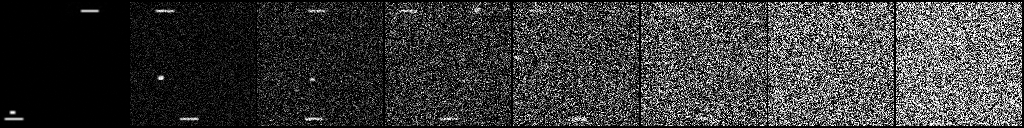

In [39]:
noise = torch.randn_like(train_batch_images) # same shape as xb: [Batch size, Channels, Height, Width]

noisy_train_batch_images = schedulers["cosine"].add_noise(train_batch_images, noise, timesteps)
print("Noisy X shape", train_batch_images.shape)
show_images(noisy_train_batch_images).resize((8 * 128, 128), resample=Image.NEAREST)

#### Training

In [16]:
from src.diffusion.model import DiffusionModel, load_config

In [42]:
config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size=config['training']['image_size']
in_channels=config['training']['in_channels']
out_channels=config['training']['out_channels']
timesteps = config['training']['timesteps']
beta_schedule=config['training']['beta_schedule']

model = DiffusionModel(
    image_size=image_size,
    in_channels=in_channels,
    out_channels=out_channels,
    device=device,
    timesteps=timesteps,
    beta_schedule=beta_schedule,
)

In [43]:
epochs = config["training"]["epochs"]
lr = config["training"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": config["wandb"]["run_name"],
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

Epoch 1/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]/home/aorellan/miniconda3/envs/diffusion_arcade/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0252]


Epoch [1/30] Train Loss: 0.1268 Val Loss: 0.0312


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.35s/it, loss=0.0184]


Epoch [2/30] Train Loss: 0.0229 Val Loss: 0.0187


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.0105]


Epoch [3/30] Train Loss: 0.0142 Val Loss: 0.0132


Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00873]


Epoch [4/30] Train Loss: 0.0102 Val Loss: 0.0081


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00799]


Epoch [5/30] Train Loss: 0.0092 Val Loss: 0.0076


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00633]


Epoch [6/30] Train Loss: 0.0067 Val Loss: 0.0053


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00545]


Epoch [7/30] Train Loss: 0.0060 Val Loss: 0.0046


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.0055]


Epoch [8/30] Train Loss: 0.0046 Val Loss: 0.0043


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00402]


Epoch [9/30] Train Loss: 0.0043 Val Loss: 0.0042


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00311]


Epoch [10/30] Train Loss: 0.0038 Val Loss: 0.0037


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00251]


Epoch [11/30] Train Loss: 0.0034 Val Loss: 0.0032


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00267]


Epoch [12/30] Train Loss: 0.0027 Val Loss: 0.0023


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00221]


Epoch [13/30] Train Loss: 0.0025 Val Loss: 0.0026


Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00238]


Epoch [14/30] Train Loss: 0.0028 Val Loss: 0.0024


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00182]


Epoch [15/30] Train Loss: 0.0021 Val Loss: 0.0027


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0018]


Epoch [16/30] Train Loss: 0.0022 Val Loss: 0.0021


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00202]


Epoch [17/30] Train Loss: 0.0025 Val Loss: 0.0018


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00214]


Epoch [18/30] Train Loss: 0.0022 Val Loss: 0.0019


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00254]


Epoch [19/30] Train Loss: 0.0019 Val Loss: 0.0025


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00159]


Epoch [20/30] Train Loss: 0.0021 Val Loss: 0.0019


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00132]


Epoch [21/30] Train Loss: 0.0020 Val Loss: 0.0021


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00162]


Epoch [22/30] Train Loss: 0.0018 Val Loss: 0.0013


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00199]


Epoch [23/30] Train Loss: 0.0018 Val Loss: 0.0021


Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00132]


Epoch [24/30] Train Loss: 0.0016 Val Loss: 0.0015


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00126]


Epoch [25/30] Train Loss: 0.0015 Val Loss: 0.0016


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00116]


Epoch [26/30] Train Loss: 0.0016 Val Loss: 0.0014


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00145]


Epoch [27/30] Train Loss: 0.0015 Val Loss: 0.0013


Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00114]


Epoch [28/30] Train Loss: 0.0014 Val Loss: 0.0014


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00118]


Epoch [29/30] Train Loss: 0.0014 Val Loss: 0.0017


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00114]


Epoch [30/30] Train Loss: 0.0016 Val Loss: 0.0019


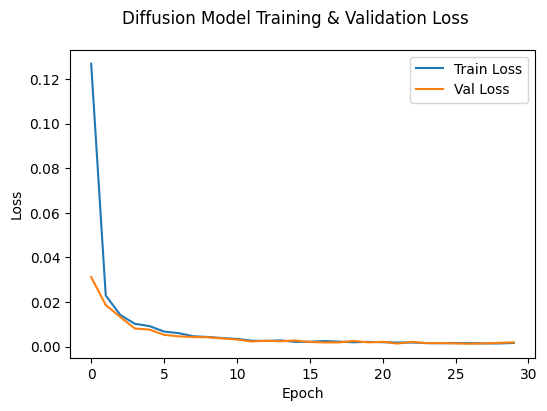

In [44]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Diffusion Model Training & Validation Loss")

ax.plot(train_losses, label="Train Loss")
ax.plot(val_losses, label="Val Loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

#### Generation

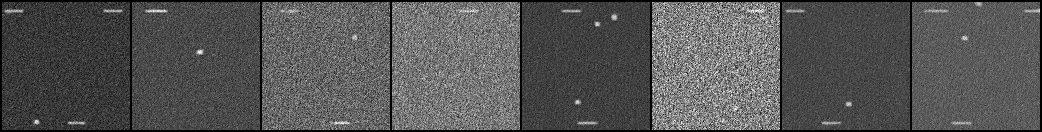

In [65]:
n_images = 8
n_channels = 1
num_inference_steps = 110

sample = model.generate(n_images, n_channels, num_inference_steps)

show_images(sample)

## References

1. **Hugging Face Diffusion Course, Unit 0: Introduction to Diffusion Models**  
   Available online: [https://huggingface.co/learn/diffusion-course/en/unit0/1](https://huggingface.co/learn/diffusion-course/en/unit0/1)

2. **Ho, J., Jain, A., & Abbeel, P.** (2020). *Denoising Diffusion Probabilistic Models*.  
   arXiv preprint arXiv:2006.11239. [PDF](https://arxiv.org/pdf/2006.11239)

3. **Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B.** (2022). *High-Resolution Image Synthesis with Latent Diffusion Models*.  
   arXiv preprint arXiv:2208.11970. [PDF](https://arxiv.org/pdf/2208.11970)
